In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import torch
import gymnasium as gym
import gym_bart
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import forced_action_evaluate as evalu
from model_evaluation import bart_toggle_data_callback, meta_bart_callback
from bart_behavior_analysis import (
    color_to_idx, 
    idx_to_color, 
    bart_plot_colors,
    plot_bart_behaviors,
    get_bart_res_eps,
    plot_3color_it_rt,
    plot_3color_meta_ep,
)
from read_experiments import average_runs, load_exp_df

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env

set_rc()
evalu = partial(evalu, data_callback=bart_toggle_data_callback,
                env_name="BartEnv-v0", num_episodes=100)

In [10]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/behav/behav_t0/50.pt')

In [11]:
res = evalu(model, obs_rms, num_episodes=1000, deterministic=False)
colors = np.array(res['data']['color'])
end_size = np.array(res['data']['end_size'])
popped = np.array(res['data']['popped'])
reaction_times = np.array(res['data']['inflate_delay'])

SubplotGrid(nrows=3, ncols=3, length=9)

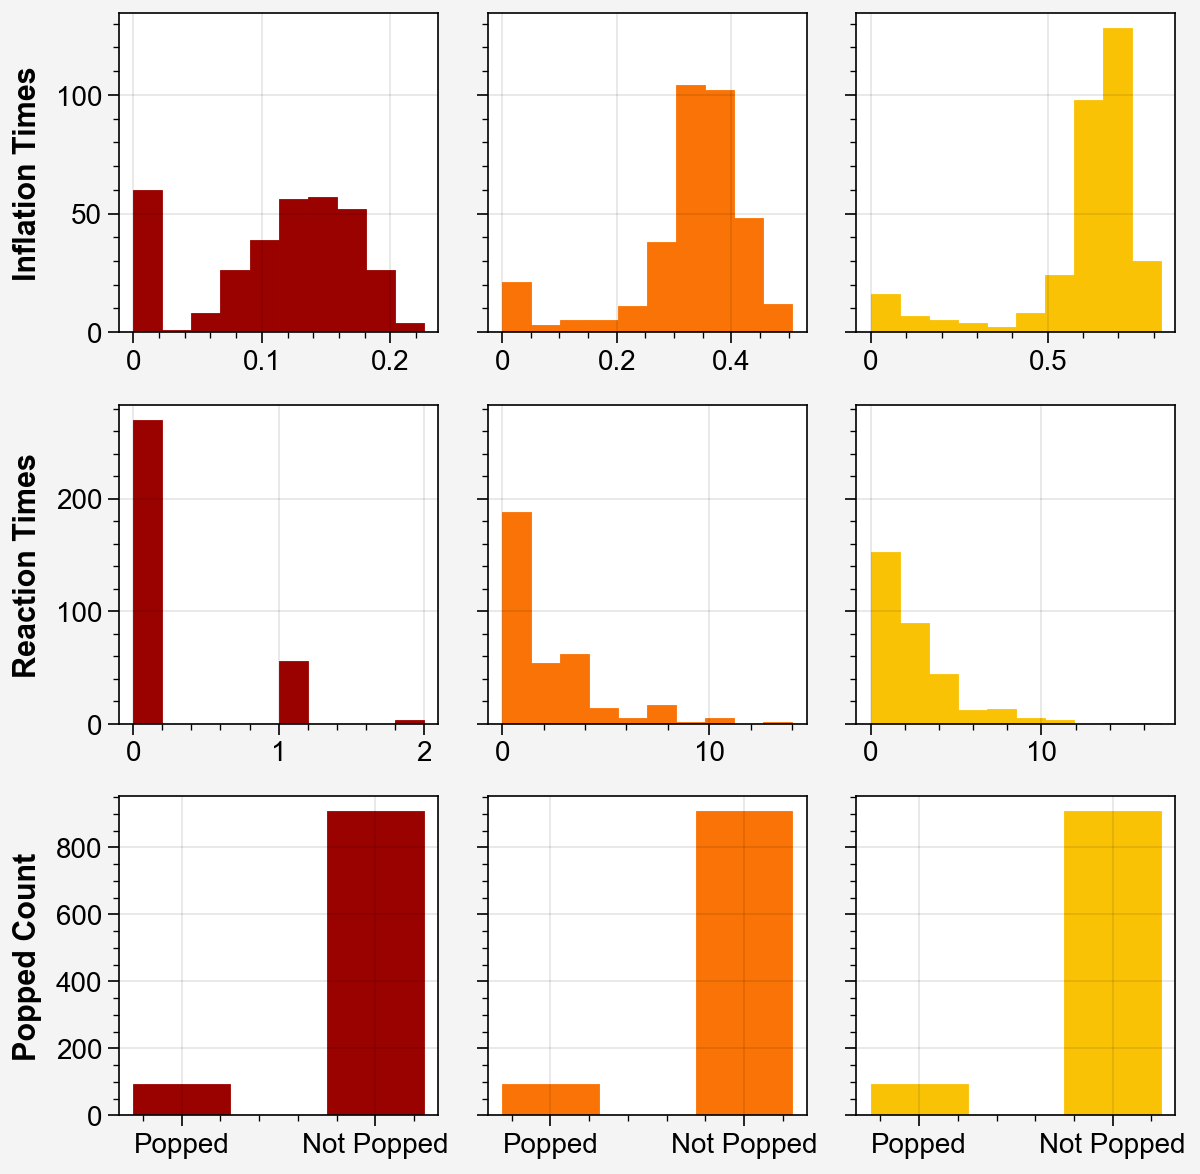

In [92]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/behav/behav_t0/20.pt')
res = evalu(model, obs_rms, num_episodes=1000, deterministic=False)
plot_3color_it_rt(res, metrics=['size', 'rt', 'popped'])

SubplotGrid(nrows=2, ncols=3, length=6)

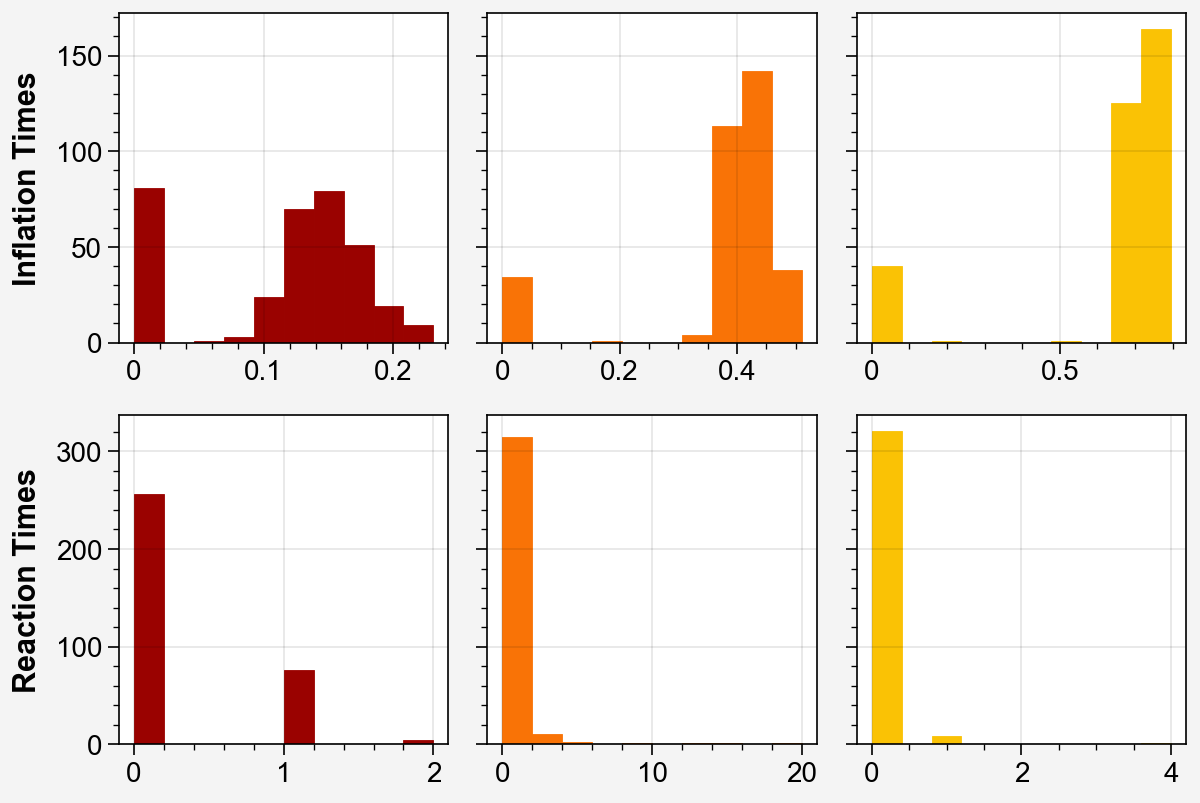

In [4]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/behav/behav_t0/100.pt')
res = evalu(model, obs_rms, num_episodes=1000, deterministic=False)
plot_3color_it_rt(res)

SubplotGrid(nrows=3, ncols=3, length=9)

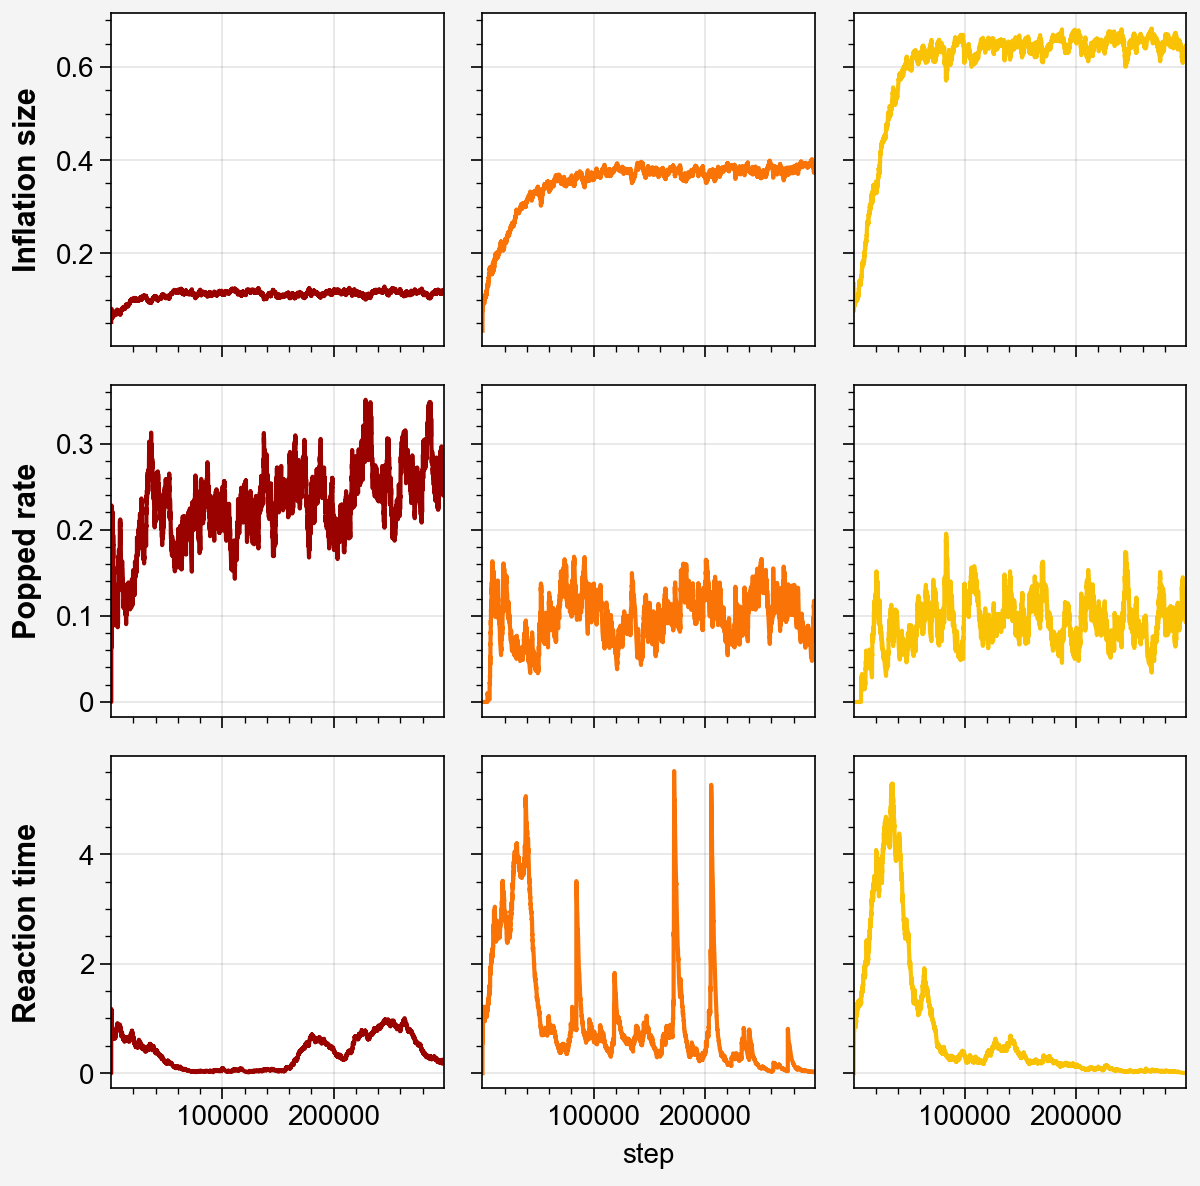

In [70]:
df = load_exp_df('behav/behav', trial_num=0)
plot_bart_behaviors(df, metrics=['size', 'popped', 'rt'])

In [95]:
fres = get_bart_res_eps(res, color=['red'], min_rt=2)
len(fres['obs'])

3

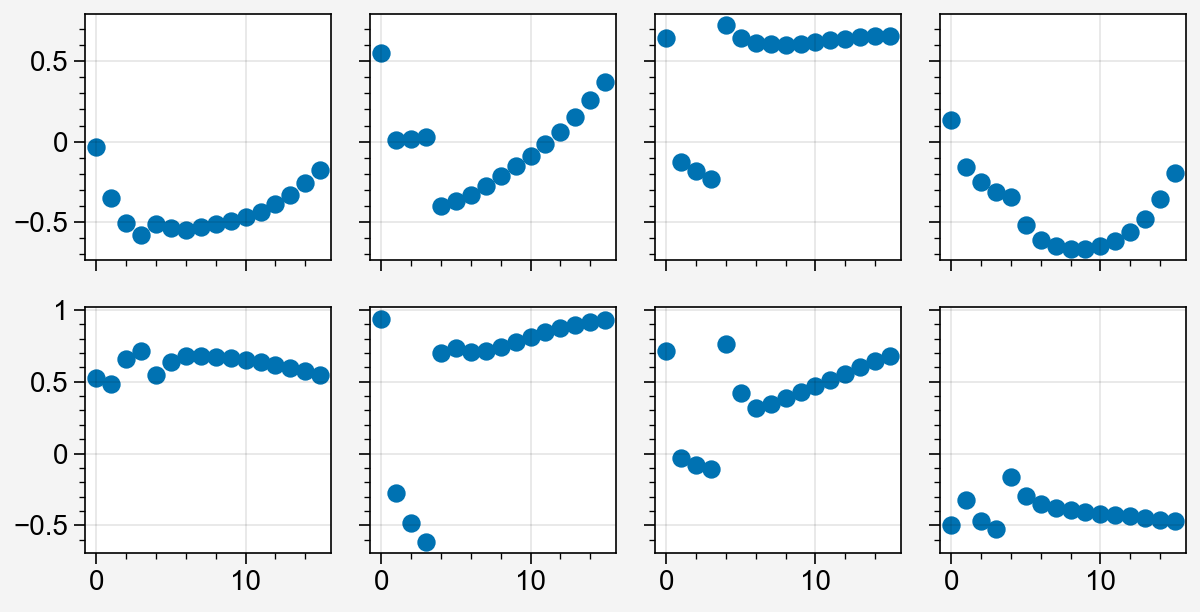

In [66]:
fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)
ep = 2
rnn_hxs = fres['rnn_hxs'][ep]
for i in range(8):
    ax[i].scatter(rnn_hxs[:, i])

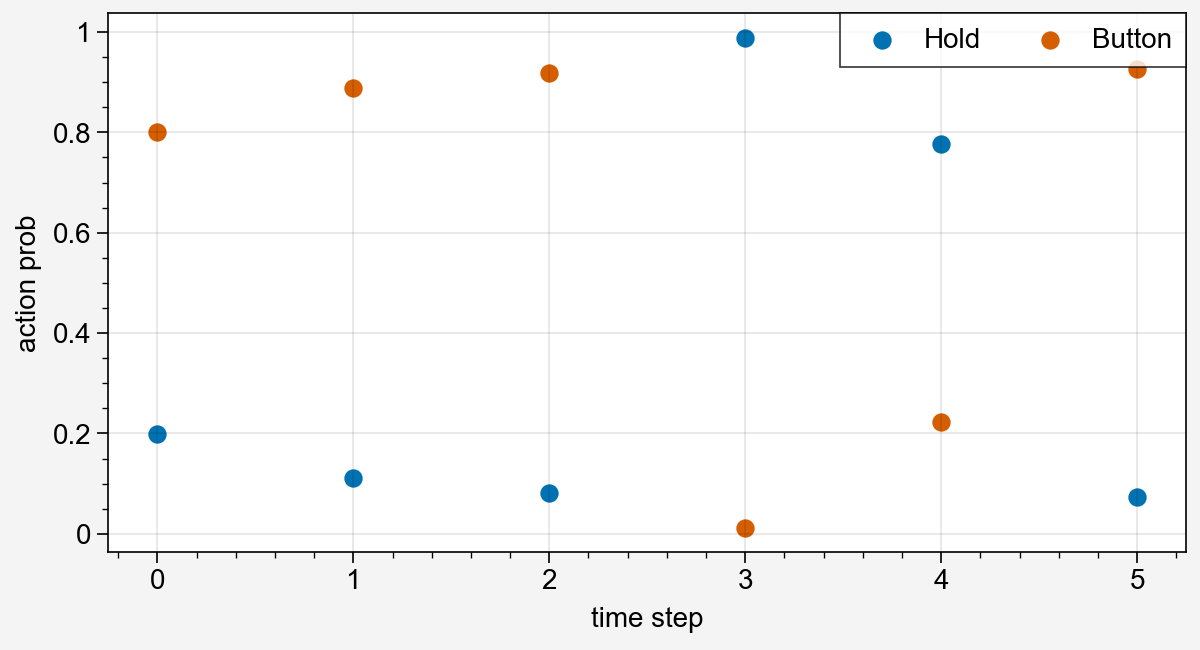

In [96]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
ep = 0
aps = fres['action_probs'][ep]
labels = ['Hold', 'Button']
for i in range(2):
    ax.scatter(aps[:, i], label=labels[i])
ax.format(ylabel='action prob', xlabel='time step')
ax.legend()

# MetaBart

In [18]:
evalu = partial(evalu, data_callback=meta_bart_callback,
                env_name="BartMetaEnv", num_episodes=10)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


ValueError: too many values to unpack (expected 2)

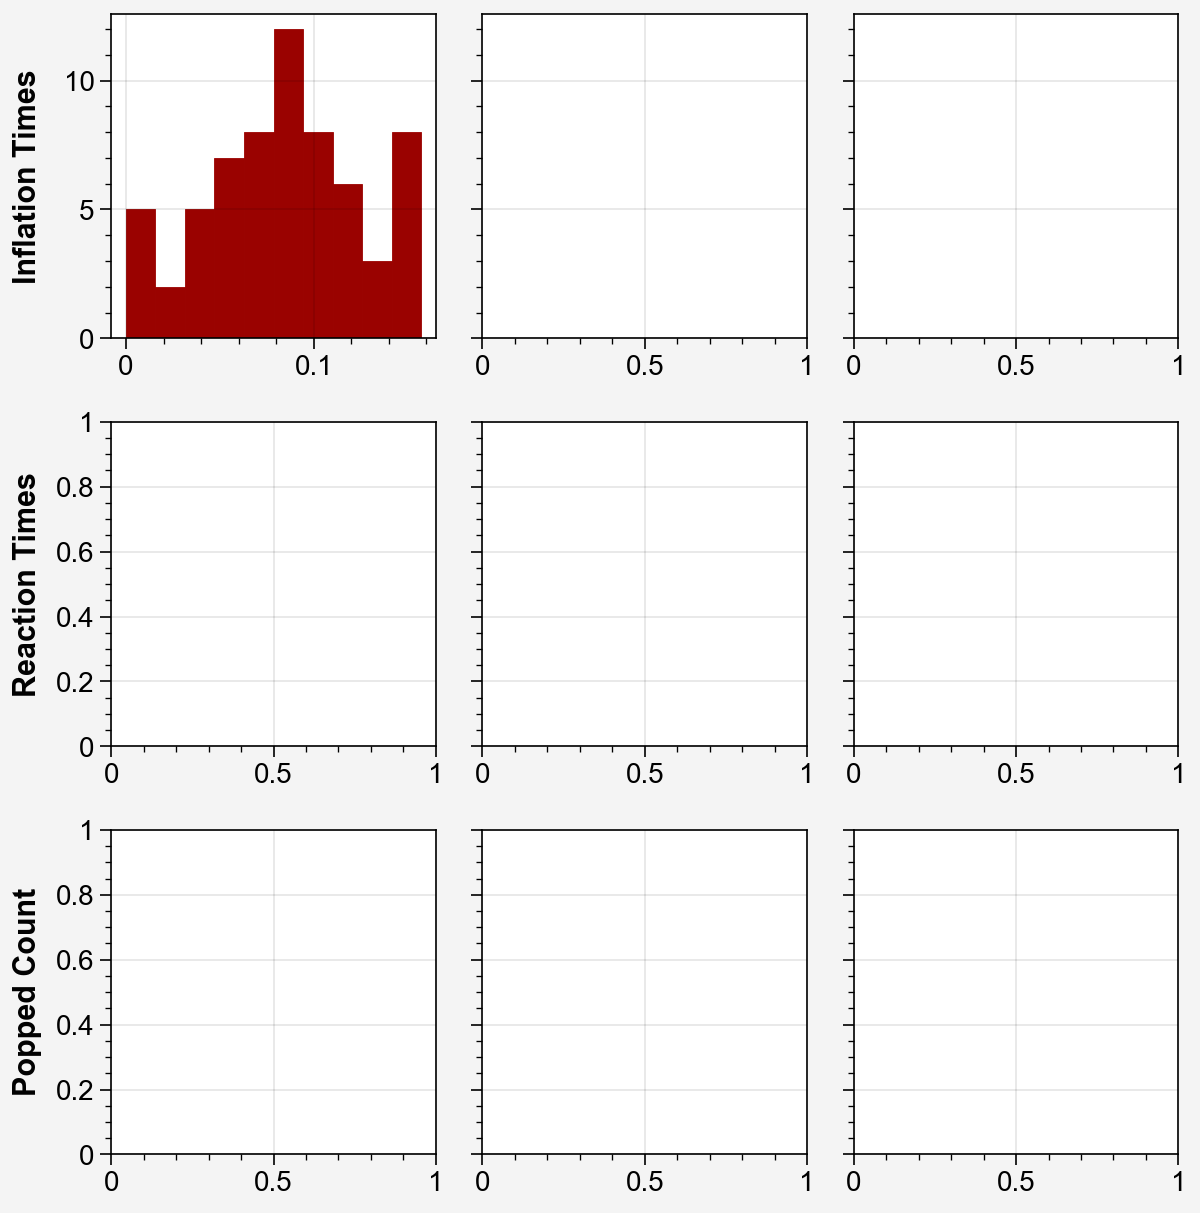

In [14]:
model, (obs_rms, ret_rms) = torch.load('../saved_checkpoints/meta/meta_t0/200.pt')
res = evalu(model, obs_rms, deterministic=False)
plot_3color_meta_ep(res, metrics=['size', 'rt', 'popped'], ep_num=3)

In [52]:
%run model_evaluation
%run bart_behavior_analysis

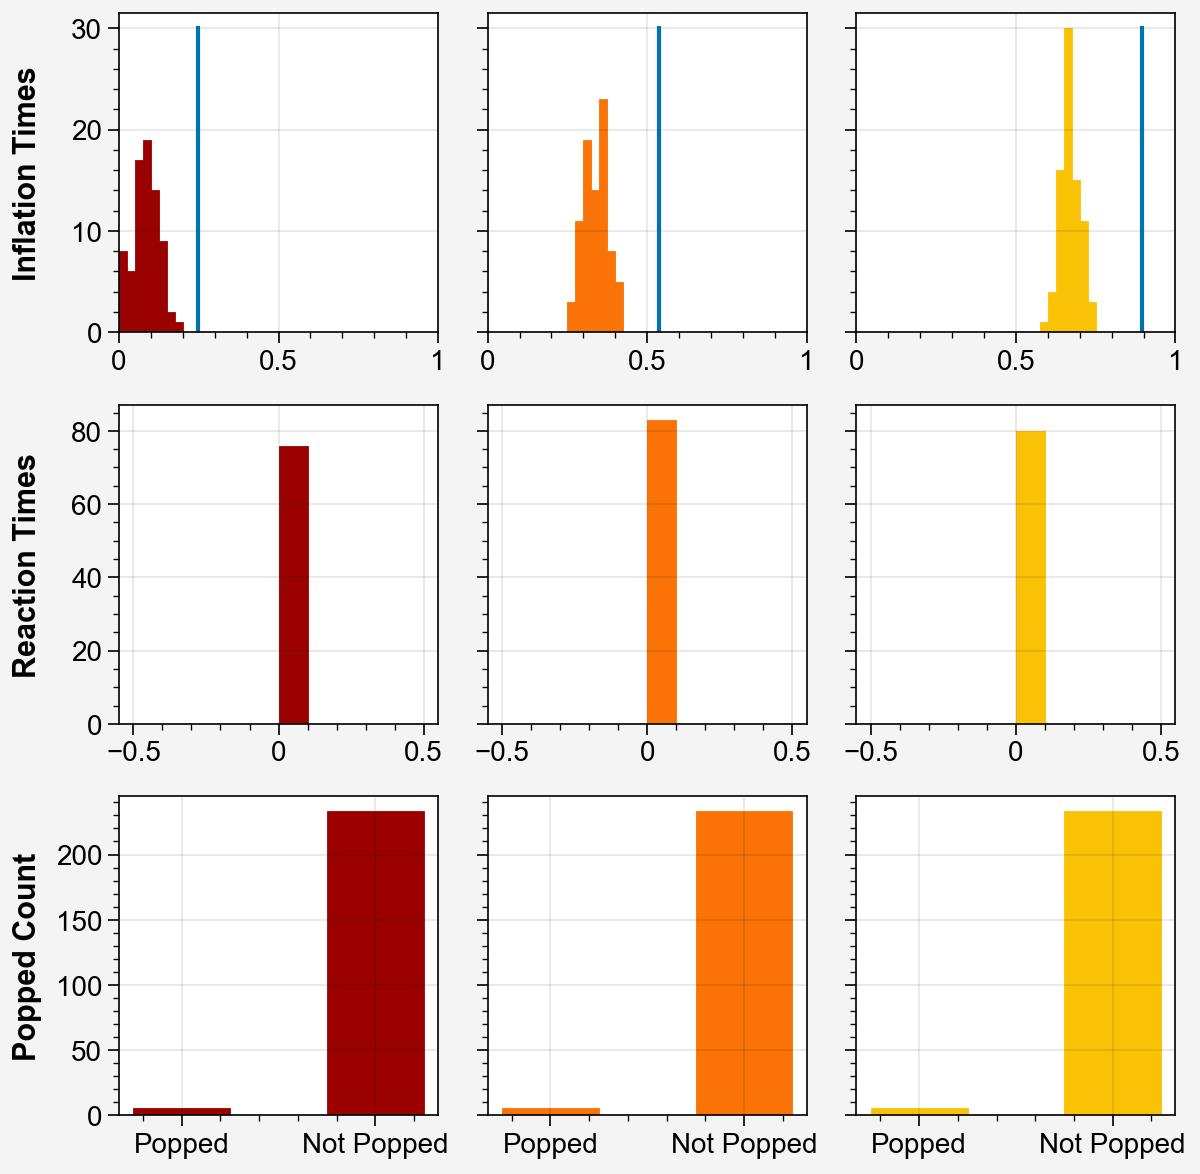

In [57]:
ax = plot_3color_meta_ep(res, metrics=['size', 'rt', 'popped'], ep_num=5)

In [63]:
ep_num = 5
colors = np.array(res['data']['current_color'][ep_num])
end_size = np.array(res['data']['last_size'][ep_num])

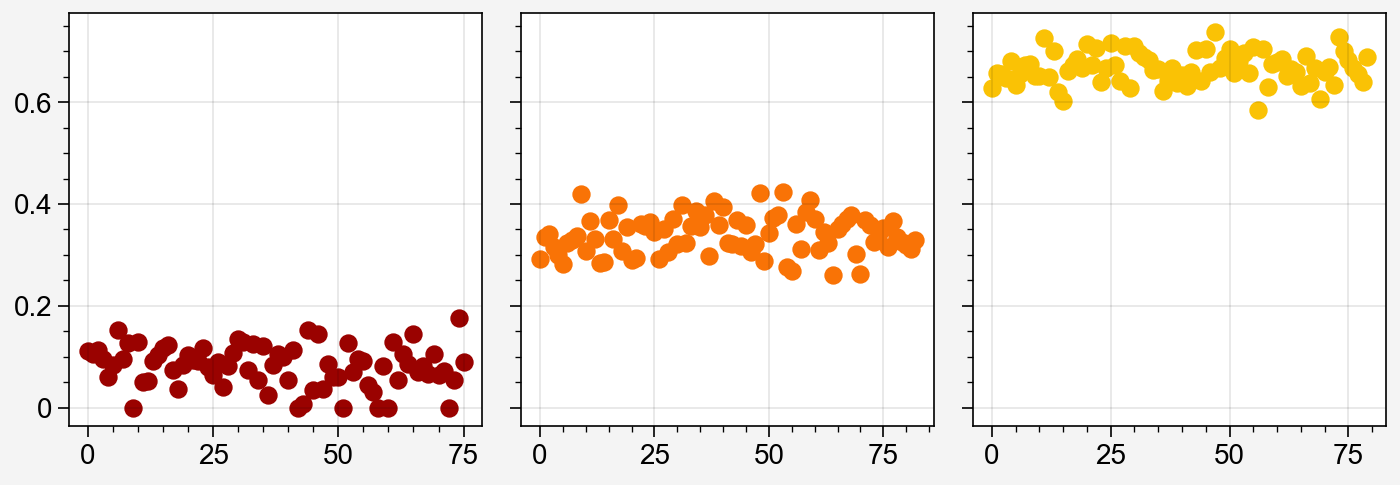

In [64]:
fig, ax = pplt.subplots(nrows=1, ncols=3, figwidth=7)
for j in range(3):
    its = end_size[colors == j]
    ax[j].scatter(np.arange(len(its)), its, c=bart_plot_colors[j])